# 枚举高手的 bomblab 审判

本题最大的挑战是绕过反调试，剩下的部分就是一个bomblab。我遇到的最大挑战是真不会用IDA，是Gemini指导手把手教我的。

### Flag 1

先拖进IDA，一个个函数F5看过去。有两个函数看着就不大常规：

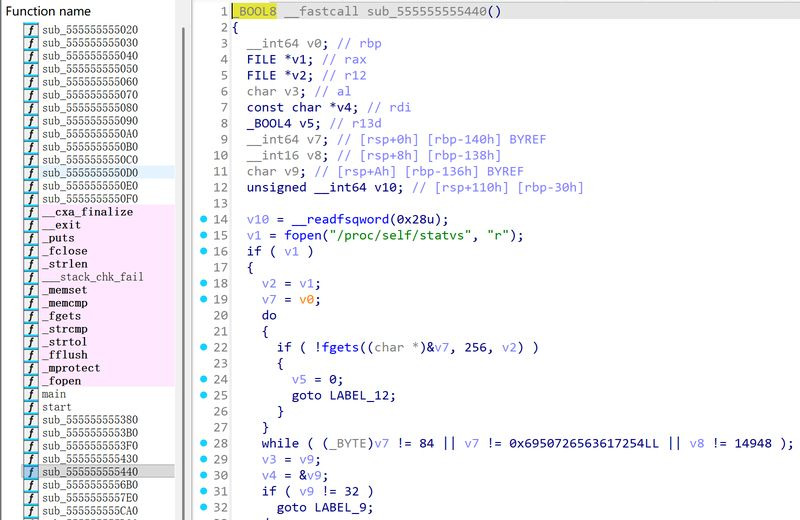

GPT指导：这段代码是在做 “检查进程是否被调试（是否被 ptrace 附加）”。
用一句话说：它打开 /proc/self/status，找到以 TracerPid: 开头的那一行，读取冒号后面的数字，若该数字不为 0 就返回 true（表示被调试器附着），否则返回 false。

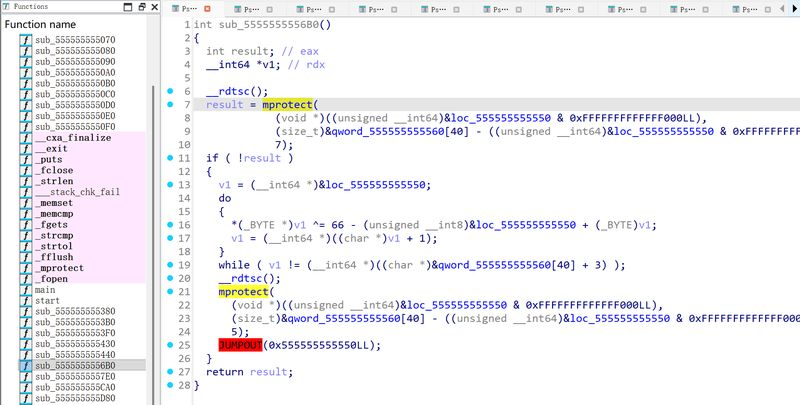

GPT指导：
它先用 mprotect() 将某个段（loc_555555555550 开头，直到 qword_555555555560[40] + 3）设置成可写可执行（权限 7 = RWX）。
然后在那段内存做逐字节异或变换（*v1 ^= ...），也就是“解密／变形”那段代码或数据。
再调用 mprotect() 把那段内存的权限改回 “5”（即 R-X：可读可执行，不可写）— 防止调试器注入或篡改。
最后做一个跳转 JUMPOUT(0x555555555550) 跳进那段刚刚解密／变形的代码。
上下都有 __rdtsc() 调用。那可能是用来检测调试/中断，或者只是用来“计时差”看有没有断点停顿。
总之，这是个“Self-modifying code + timing check”的保护函数。


静态分析不了一点，得先想办法干掉反调试。干掉反调试有两种方案：
- 创建一个特殊的环境让它的反调试方法失效
  
  可以编译一个[特殊的内核模块](https://github.com/tfoldi/ko-undebug) 让TracerPid永远返回0。

- 直接Patch代码干掉它的反调试逻辑

  这是本题最简单的解法，因为它读不到`/proc/self/status`也会返回false。那我们把路径改成`/proc/self/statvs`就行了。IDA的Patch Program就很适合干这事。

  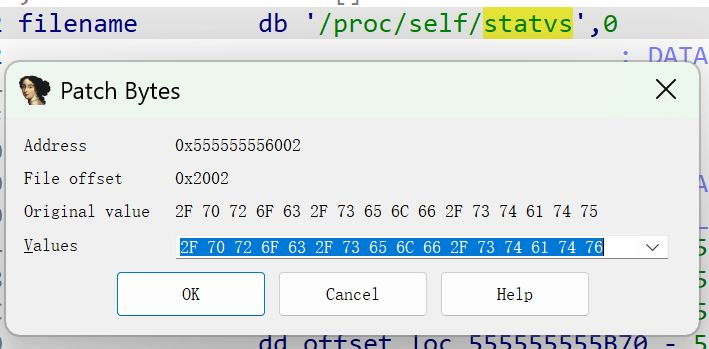

从main里可以看出，两个flag的校验逻辑分别在`sub_555555555D80` 和`sub_5555555557E0`，其中`sub_555555555D80`看着比较简单，应该是Flag1。

还确实比较简单，IDA调试器下断点直接出了。


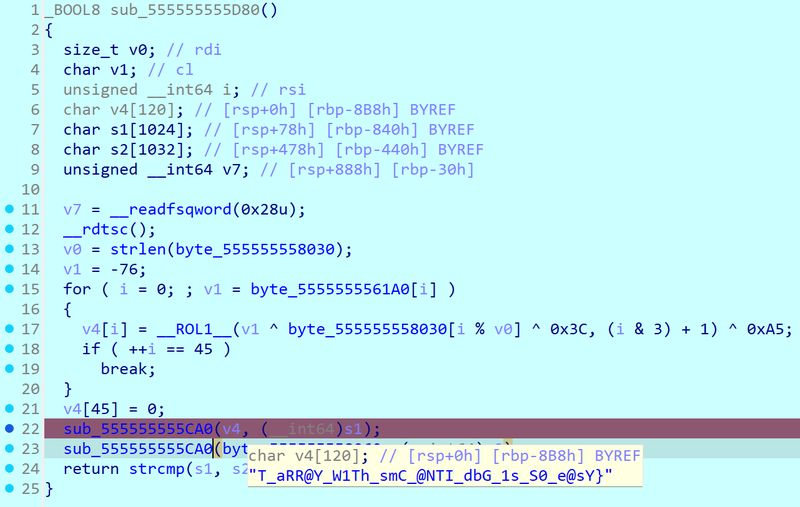

### Flag 2



好复杂看不懂啊。交给GPT指导：

```c
v0 = strlen(byte_...8060);
if (v0 == 39) { ... RC4-VM ... }
```

→ **输入长度恰好为 39** 。

函数开头：

```c
memset(v48, 0, 0x4000);
qmemcpy(v50, "\nsneaky_key", 11);  // 注意前导 '\n'，总长 11
qmemcpy(v51, user_input, 39);      // 保存你的输入
memset(&v47[2], 0, 0x838);
```

* `v48`/`v47`/`v50`/`v51` 是这台小 VM 的“内存”和“栈/寄存器”。命名上 v48 实际被当成 0x4000 大缓冲用（反编译显示为 16 字节是 IDA 的栈还原假象）。
* 之后开始逐字节解释某段字节码（`byte_555555556100` 及其分段 `...6100/6102/6104`），指令集包含：

  * `0x01`：push 1 字节立即数
  * `0x03`：push 4 字节立即数
  * `0x04`：pop
  * `0x05`：dup（把栈顶复制到下一槽）
  * `0x20`/`0x21`：从 VM 的 0x4000 区读/写一个字节到/自栈顶
  * `'@' (0x40)`：**RC4 KSA**（用之前在 0x4000 区准备好的密钥材料构建 S 盒）
  * `'A' (0x41)`：**RC4 PRGA** + XOR：`dest[i] = src[i] ^ keystream[i]`
  * `0`：结束
* 每个 `@` 或 `A` 都从栈上取参数（S 盒位置、key 起始&长度、i/j 索引保存位置、src/dst 起始、处理字节数……），并做严密的越界检查；一旦出错就立即走“失败路径”。

最后：

```c
return memcmp(&v52, &unk_555555556160, 0x27) == 0;  // 0x27=39
```

也就是说 VM 运行的结果会把**某段内存**写到 `v52`，并与 `.rodata` 里的 39 字节常量比较。**相等则通过**。

刚刚做过ransomware的同学肯定能领会XOR操作的神奇。这个RC4 VM最后无论如何都会把输出和`6160`中的数据比较，而KEYSTREAM一定是不变的。既然 FLAG2 ^ KEYSTREAM = var6160，我们通过调试能得到 INPUT ^ KEYSTREAM = v52，那就有FLAG2 = var6160 ^ v52 ^ INPUT。调试器，启动！


In [1]:
def _read_bytes(byt: list[str]) -> bytes:
    return b"".join(int.from_bytes(bytes.fromhex(x), "little").to_bytes(8, "big") for x in byt)

var_6160 = _read_bytes(["BEC81CE1C0E65B1C", "9910AC87C294B0F3", "565B4023F588BF84", "F441B03BEE9D81BE", "00BFF561D7CB6542"])
var_6160 = var_6160[:39]
var_6160

b'\x1c[\xe6\xc0\xe1\x1c\xc8\xbe\xf3\xb0\x94\xc2\x87\xac\x10\x99\x84\xbf\x88\xf5#@[V\xbe\x81\x9d\xee;\xb0A\xf4Be\xcb\xd7a\xf5\xbf'

In [4]:
INPUT = b"flag{" + b"F"*33 + b"}"
print(INPUT)

b'flag{FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF}'


In [8]:
def _parse_bytes(byt: str) -> bytes:
    res = bytearray()
    for l in byt.splitlines():
        h = l.split()[1].strip()
        res.extend(int.from_bytes(bytes.fromhex(h), "little").to_bytes(8, "big"))
    return bytes(res)

# v52在调试器里dump出来的结果
gt_bytes = _parse_bytes("""00007FFFFFFFA330  ABCF1FE1C0E65B1C
00007FFFFFFFA338  9625BF9EC984A9EC
00007FFFFFFFA340  71423226C1919E8C
00007FFFFFFFA348  C158854CF7B4A0B4
00007FFFFFFFA350  00BFEA74D1C87C34""")
gt_bytes

b'\x1c[\xe6\xc0\xe1\x1f\xcf\xab\xec\xa9\x84\xc9\x9e\xbf%\x96\x8c\x9e\x91\xc1&2Bq\xb4\xa0\xb4\xf7L\x85X\xc14|\xc8\xd1t\xea\xbf\x00'

In [7]:
def bitwise_xor(data1: bytes, data2: bytes) -> bytes:
    return bytes([a ^ b for a, b in zip(data1, data2)])

bitwise_xor(bitwise_xor(gt_bytes, var_6160), INPUT)

b'flag{EASY_VM_UsINg_rC4_aLgo_1s_s0_E@SY}'